Se desea obtener 3 modelos distintos para un conjunto de datos






Importamos los datos

In [ ]:
import gdown

url = ' '
output = ' '
gdown.download(url, output, quiet=False)

Downloading...
From:  To: /content/properatti_filtered.csv
100%|██████████| 11.5M/11.5M [00:00<00:00, 49.5MB/s]


'properatti_filtered.csv'

Importamos librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = pd.read_csv('/content/properatti_filtered.csv')

data.dtypes

Unnamed: 0.1               int64
Unnamed: 0                 int64
property_type             object
state_name                object
location_name             object
lat                      float64
lon                      float64
price                    float64
surface_covered_in_m2    float64
price_per_m2             float64
rooms                    float64
balcon                      bool
parrilla                    bool
cochera                     bool
patio                       bool
pileta                      bool
lavadero                    bool
dtype: object

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools import eval_measures
from sklearn import linear_model

## Análisis de selección de subconjunto

Retomemos el análisis del comienzo. Debemos tomar un criterio sobre que barrios/ciudades seleccionar. Para eso buscaremos cierta cantidad de ciudades que tengan un "comportamiento parecido" y que se tenga una cantidad mayor a 2000 datos. Para eso se planteó el siguiente analisis:

In [ ]:
data["state_name"].value_counts()

Capital Federal                 25661
Bs.As. G.B.A. Zona Norte        21681
Bs.As. G.B.A. Zona Sur           9927
Buenos Aires Costa Atlántica     6988
Bs.As. G.B.A. Zona Oeste         6164
Córdoba                          3907
Santa Fe                         1579
Buenos Aires Interior            1320
Name: state_name, dtype: int64

Descartamos Santa Fe y el interior de Buenos Aires porque tienen menos de 2000 valores

In [ ]:
data['property_type']

0                  PH
1        Departamento
2        Departamento
3                  PH
4        Departamento
             ...     
77222    Departamento
77223    Departamento
77224            Casa
77225    Departamento
77226    Departamento
Name: property_type, Length: 77227, dtype: object

In [ ]:
data.loc[data['state_name']=="Córdoba"].property_type.value_counts()

Casa            2046
Departamento    1623
Local            131
PH               107
Name: property_type, dtype: int64

In [ ]:
data.loc[data['state_name']=="Córdoba"].location_name.value_counts()

Córdoba             2722
Punilla              336
Villa Carlos Paz     307
Villa Allende         88
Santa María           72
                    ... 
Hernando               1
Tancacha               1
Monte Cristo           1
San Vicente            1
Mi Granja              1
Name: location_name, Length: 80, dtype: int64

En base a los datos de Córdoba podriamos trabajar únicamente con casas de Córdoba Capital y no superariamos el límite de los 2000. Tampoco consideramos un buen criterio mezclar departamentos con casas. Por lo que se descarta Córdoba

In [ ]:
data.loc[data['state_name']=="Córdoba"].property_type.value_counts()

Casa            2046
Departamento    1623
Local            131
PH               107
Name: property_type, dtype: int64

### Zona Oeste

Para analizar Zona Oeste se debe considerar que en esta descripción se están tomando municipios y no ciudades. Un municipio es un conjunto de ciudades en donde hay mucha variabilidad de precios

In [ ]:
import scipy.stats as stats

In [ ]:
data[data['state_name']=="Bs.As. G.B.A. Zona Oeste"]["location_name"].value_counts()

Morón                1920
La Matanza           1806
Tres de Febrero       945
Ituzaingó             570
Moreno                429
Merlo                 180
Hurlingham            128
General Rodríguez     122
Marcos Paz             64
Name: location_name, dtype: int64

La división que se tiene en el dataset es por partido, y los precios por partido tienen una variación muy alta como para estudiarla

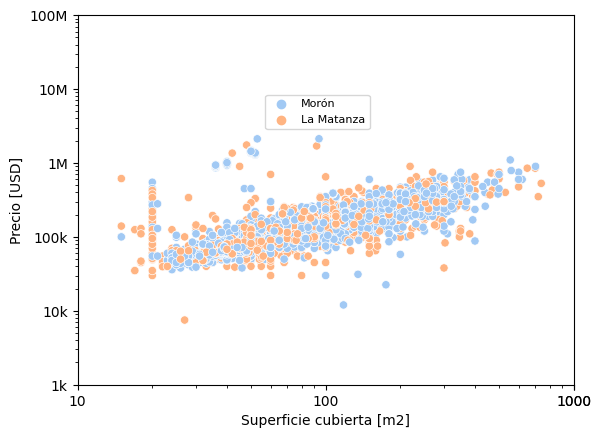

In [ ]:
zona= ['Morón', 'La Matanza']
data_filtrada=data[data['location_name'].isin(zona)]
data_filtrada
#barrio =['Morón', 'La Plata']
#data_filtrada= data[data['location_name'].isin(zona)]
#Graficamos un scatterplot
sns.scatterplot(data=data_filtrada, y="price", x="surface_covered_in_m2", hue="location_name", palette= 'pastel')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Superficie cubierta [m2]')
plt.ylabel('Precio [USD]')
plt.xlim([10,1000])
plt.legend(bbox_to_anchor =(0.6, 0.8), prop={'size': 8})
plt.xticks([10,100,1000,1000],[10,100,1000,1000])
plt.yticks([1000,10000,100000,1000000,10000000,100000000],["1k","10k","100k","1M","10M","100M"])
plt.show()

In [ ]:
def intervalo_de_confianza_dif(data, x1, x2, col='price'):
  x1=data[data['location_name'] == x1][col]
  x2=data[data['location_name'] == x2][col]
  alpha = 0.05                                                 # significance level = 5%
  n1, n2 = len(x1), len(x2)                                    # sample sizes
  s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)              # sample variances
  s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # pooled standard deviation
  df = n1 + n2 - 2                                             # degrees of freedom
  t = stats.t.ppf(1 - alpha/2, df)                             # t-critical value for 95% CI

  lower = (np.mean(x1) - np.mean(x2)) - t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
  upper = (np.mean(x1) - np.mean(x2)) + t * np.sqrt(1 / len(x1) + 1 / len(x2)) * s
  _,pvalor = stats.ttest_ind(x1, x2, equal_var=True)
  zero_is_in = lower <= 0 <= upper
  return lower, upper, pvalor, zero_is_in


In [ ]:
x1 = 'La Matanza'
x2 = 'Morón'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data, x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)

(-35088.79509253659, -10358.686873854796)
0.000318587830779876
False


En base a estos datos podemos rechazar la hipotesis de que las medias no tienen una diferencia. Por lo que son distintas como para analizarlas en el mismo dataset

### Zona Sur

En Zona sur tenemos más cantidad de propiedades. Ahora si sería necesario separar en casas y PHs

In [ ]:
data[data['state_name']=="Bs.As. G.B.A. Zona Sur"]["location_name"].value_counts()

Lomas de Zamora       2808
La Plata              1954
Lanús                 1424
Almirante Brown       1140
Quilmes                573
Avellaneda             557
Esteban Echeverría     490
Ezeiza                 377
Berazategui            342
Presidente Perón       105
San Vicente             92
Cañuelas                38
Florencio Varela        27
Name: location_name, dtype: int64

Partamos de Lomas de Zamora, La Plata, Lanús y Almirante Brown

In [ ]:
x1 = 'Lomas de Zamora'
x2 = 'La Plata'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data, x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)

(-11793.38036878346, 14377.961524772023)
0.8464912968986853
True


In [ ]:
x1 = 'Lomas de Zamora'
x2 = 'La Plata'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data, x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)

(-11793.38036878346, 14377.961524772023)
0.8464912968986853
True


In [ ]:
x1 = 'Lomas de Zamora'
x2 = 'Almirante Brown'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data, x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)

(-43097.39615336859, -14175.173203790784)
0.00010513743596471274
False


Rechazo todos excepto Lomas de Zamora y La Plata. Ahora sería util analizar si se usan departamentos o casas

In [ ]:
##print('\n Casas \n')
print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="Casa"]["location_name"].value_counts())
print('\n Departamentos \n')
print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="Departamento"]["location_name"].value_counts())
print('\n PH \n')
print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="PH"]["location_name"].value_counts())

Lomas de Zamora       1322
La Plata               870
Almirante Brown        857
Lanús                  545
Esteban Echeverría     403
Ezeiza                 233
Berazategui            232
Quilmes                194
Avellaneda             106
Presidente Perón       101
San Vicente             88
Cañuelas                33
Florencio Varela        17
Name: location_name, dtype: int64

 Departamentos 

Lomas de Zamora       1211
La Plata               893
Lanús                  587
Avellaneda             368
Quilmes                336
Almirante Brown        214
Ezeiza                 130
Berazategui            107
Esteban Echeverría      77
Florencio Varela         8
Cañuelas                 3
San Vicente              3
Presidente Perón         1
Name: location_name, dtype: int64

 PH 

Lanús                 207
Lomas de Zamora       140
La Plata              116
Avellaneda             57
Quilmes                36
Almirante Brown        30
Esteban Echeverría      4
Ezeiza                 

<ipython-input-18-d585a0553e04>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="Casa"]["location_name"].value_counts())
<ipython-input-18-d585a0553e04>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="Departamento"]["location_name"].value_counts())
<ipython-input-18-d585a0553e04>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name']=="Bs.As. G.B.A. Zona Sur"][data['property_type']=="PH"]["location_name"].value_counts())


Descarto los PH y analizo los departamentos y las casas. Nuevamente hacemos el análisis del intervalo de confianza pero unicamente para casas y para departamentos por separado:

In [ ]:
x1 ='Lomas de Zamora'
x2 ='La Plata'

print('\n Casas por precio\n')
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"], x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)
print('\n Casas por superficie\n')
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"], x1, x2, 'surface_covered_in_m2')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)

print('\n Departamentos por precio\n')
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"], x1, x2, 'price')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)


print('\n Departamentos por superficie\n')
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"], x1, x2, 'surface_covered_in_m2')
print(f'({lower}, {upper})')
print(pvalor)
print(zero_is_in)


 Casas por precio

(-34045.78898274216, 317.66804639719703)
0.054384965881640004
True

 Casas por superficie

(-23.919144819986695, 18.21716871273021)
0.7907469677691542
True

 Departamentos por precio

(4278.5150876520565, 18863.309904546528)
0.0018852369458693086
False

 Departamentos por superficie

(-7.71201777302201, -0.3498941892721077)
0.03186752680608999
False


Basado en este criterio podríamos trabajar con el conjunto:

Casas de La plata y Lomas de Zamora ya que no hubo información suficiente como para rechazarlos y suman 2192 casas

### Zona Norte

In [ ]:
print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"]["location_name"].value_counts())


print("\n Casas \n")

print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="Casa"]["location_name"].value_counts())

print("\n Departamentos \n")

print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="Departamento"]["location_name"].value_counts())

print("\n PH \n")

print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="PH"]["location_name"].value_counts())

Tigre                  7617
Vicente López          3451
San Isidro             2724
Pilar                  2676
Escobar                1585
General San Martín     1377
San Fernando            948
San Miguel              821
Malvinas Argentinas     389
José C Paz               93
Name: location_name, dtype: int64

 Casas 

Tigre                  4317
Pilar                  1901
Escobar                1503
San Isidro             1458
Vicente López          1109
General San Martín      448
San Miguel              408
San Fernando            334
Malvinas Argentinas     314
José C Paz               65
Name: location_name, dtype: int64

 Departamentos 

Tigre                  3233
Vicente López          1904
San Isidro              985
Pilar                   716
General San Martín      595
San Fernando            521
San Miguel              366
Escobar                  59
Malvinas Argentinas      53
José C Paz               17
Name: location_name, dtype: int64

 PH 

Vicente López          

<ipython-input-20-b352caa2b5d4>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="Casa"]["location_name"].value_counts())
<ipython-input-20-b352caa2b5d4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="Departamento"]["location_name"].value_counts())
<ipython-input-20-b352caa2b5d4>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Bs.As. G.B.A. Zona Norte"][data['property_type']=="PH"]["location_name"].value_counts())


Aca podemos ver que predominan las casas. Analizaré los departamentoso entre Tigre y Vicente Lopez primero


In [ ]:
x1 = 'Tigre'
x2 = 'Vicente López'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

-74678.41706149635 -55394.37965214729
2.8072215306241623e-39
False


Dan muy distintos por lo que no tendría sentido hacer un analisis de departamentos de estas regiones. Aunque si podriamos analizar departamentos unicamente de Tigre porque son 3233

In [ ]:
x1 = 'Tigre'
x2 = 'Pilar'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

122715.28034365333 162153.38160774234
8.020732853065788e-45
False
122715.28034365333 162153.38160774234
8.020732853065788e-45
False


In [ ]:
x1 = 'Belgrano'
x2 = 'Recoleta'
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data,x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

-61748.46578555774 -17983.32235181613
0.0003584092690760059
False



En base al conocimiento que tenemos de estas zonas consideramos hacer las siguientes comparaciones:

Tigre- Pilar

Tigre - Escobar

Escobar - Tigre


Al considerarlos una zona de barrios privados

Luego por otro lado comparar San isidro y Vicente lopez por ser más urbanos

In [ ]:
x1 = 'Escobar'
x2 = 'Tigre'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x1 = 'Escobar'
x2 = 'Pilar'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

-266782.2086099572 -225869.0418822925
9.941570372258594e-118
False
-99.233715488022 -30.496406847802028
0.00021769889266396442
False
-120198.64227105766 -87583.94626979639
4.849151158402746e-35
False
-109.39022173907527 -41.01178572066773
1.6594313522891033e-05
False


Descarto Escobar por ser muy distintas al resto

In [ ]:
x1 = 'Tigre'
x2 = 'Pilar'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

122715.28034365333 162153.38160774234
8.020732853065788e-45
False
-46.2696399557721 25.59775483185313
0.5728613104337295
True


Tigre y Pilar tienen precios muy distintos así que nuevamente se considera que no se pueden trabajar en conjunto

In [ ]:
x1 = 'Vicente López'
x2 = 'San Isidro'


print("\n Casas \n")

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Casa"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)
print("\n Departamento \n")
lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)


 Casas 

-207109.26496979618 -107213.35434517392
7.914546283758254e-10
False
-84.62132656968241 -51.28919841544378
1.9337022425846312e-15
False

 Departamento 

-1690.854016800764 31297.552231619662
0.07855068814921766
True
-28.124509062509105 5.34934014214906
0.18227855314119992
True


Con esto podriamos concluir que no podemos combinar las casas de San Isidro y de Vicente Lopez pero si podriamos combinar los departamentos

### Capital Federal

In [ ]:
print("\n Casas \n")

print(data[data['state_name'] == "Capital Federal"][data['property_type']=="Casa"]["location_name"].value_counts())


print("\n PH \n")

print(data[data['state_name'] == "Capital Federal"][data['property_type']=="PH"]["location_name"].value_counts())


 Casas 

Palermo              99
Belgrano             97
Mataderos            90
Flores               84
Villa Devoto         72
Floresta             66
Caballito            62
Villa Urquiza        59
Villa Lugano         54
Villa del Parque     43
Barracas             42
Saavedra             41
Nuñez                39
Boedo                38
Liniers              37
Villa Pueyrredon     30
Villa Crespo         30
Parque Chacabuco     30
Villa Luro           30
Almagro              29
Colegiales           24
Versalles            21
La Boca              20
Parque Patricios     18
Paternal             18
San Cristobal        17
Nueva Pompeya        17
Coghlan              16
Parque Avellaneda    12
San Telmo            12
Velez Sarsfield      11
Monte Castro         11
Villa Gral. Mitre    11
Recoleta             10
Balvanera             8
Villa Santa Rita      6
Villa Real            6
Chacarita             6
Constitucion          5
Parque Chas           5
Villa Ortuzar         5
Monser

<ipython-input-27-cb4dab153f51>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Capital Federal"][data['property_type']=="Casa"]["location_name"].value_counts())
<ipython-input-27-cb4dab153f51>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Capital Federal"][data['property_type']=="PH"]["location_name"].value_counts())


Descartamos Casas y PHs por ser muy pocas localidades

In [ ]:
print("\n Departamentos \n")

print(data[data['state_name'] == "Capital Federal"][data['property_type']=="Departamento"]["location_name"].value_counts())


 Departamentos 

Palermo              3081
Recoleta             2155
Belgrano             2108
Caballito            1892
Villa Urquiza        1042
Balvanera             981
Flores                941
Villa Crespo          934
Almagro               806
Boedo                 730
San Telmo             715
Nuñez                 560
Puerto Madero         523
San Cristobal         475
Monserrat             427
Saavedra              407
San Nicolas           366
Villa del Parque      335
Barracas              284
Villa Luro            264
Floresta              260
Colegiales            246
Villa Devoto          221
Coghlan               198
Retiro                186
Parque Patricios      178
Chacarita             169
Constitucion          158
Liniers               146
La Boca               123
Mataderos             119
Villa Pueyrredon      101
Paternal               77
Villa Lugano           77
Villa Ortuzar          65
Parque Chacabuco       65
Monte Castro           40
Parque Chas         

<ipython-input-28-7e1a7e080466>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(data[data['state_name'] == "Capital Federal"][data['property_type']=="Departamento"]["location_name"].value_counts())


La cantidad de departamentos si es una cantidad razonable como para hacer un análisis. Analizo las primeras 5:

Palermo

Recoleta            
Belgrano             
Caballito            
Villa Urquiza

In [ ]:
x1 = 'Caballito'
x2 = 'Palermo'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x2='Belgrano'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x2='Recoleta'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x2='Villa Urquiza'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

-178872.10686875042 -138980.50085450464
9.806198558569453e-54
False
-25.660205289454453 -10.003784327052118
8.156879795552308e-06
False
-152890.8100104777 -119556.3844425473
4.679407025079883e-56
False
-36.129690423500534 -16.130087990354266
3.148741726470508e-07
False
-212323.40225492604 -179646.9209631175
9.734171407420224e-115
False
-309.1657418601442 54.000417696367464
0.16843124402480833
True
11975.950506280196 30644.935223309592
7.88060586252812e-06
False
4.82898046835234 20.477426912152694
0.0015351971763460062
False


Descarto Caballito por ser distinto a todos en precio

In [ ]:
x1 = 'Villa Urquiza'
x2 = 'Palermo'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x2='Belgrano'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

x2='Recoleta'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)


-206403.47330797208 -154070.02014487277
1.071081292173877e-40
False
-39.16851032859045 -21.801886668421155
6.745368463332269e-12
False
-178730.51180362876 -136337.56837898603
1.3427738895054819e-46
False
-50.1473664591021 -27.418819335257737
2.606549268654536e-11
False
-238050.65471571445 -196540.55423191888
4.610856354956847e-88
False
-384.84857621383713 104.3768446695554
0.26106847079862305
True


Descarto Villa Urquiza por ser muy distinto al resto

Palermo, Recoleta y Belgrano podrian usarse cada uno por separado al tener más de 2000 muestras cada uno. De todas formas planteamos la combinación a ver que se obtiene

In [ ]:
x1 = 'Belgrano'
x2 = 'Palermo'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)


-44668.4156626818 -736.9976075482518
0.042795590026135595
False
-0.6509945572096161 17.24678335455785
0.06915100640980863
True


In [ ]:
x1 = 'Recoleta'
x2 = 'Palermo'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

15401.95427382883 58715.761220959655
0.0008003736805742373
False
-32.591060861463944 252.09239540873406
0.13070790798511073
True


In [ ]:
x1 = 'Belgrano'
x2 = 'Recoleta'

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'price')
print(lower,upper)
print(pvalor)
print(zero_is_in)

lower, upper, pvalor, zero_is_in = intervalo_de_confianza_dif(data[data['property_type']=="Departamento"],x1, x2,'surface_covered_in_m2')
print(lower,upper)
print(pvalor)
print(zero_is_in)

-80229.60232361197 -39293.526441406575
1.1104232169216436e-08
False
-273.5808230972119 70.67527734729
0.24793550221224575
True


Dado que ninguna combinación incluye al 0 ni tiene un pvalor mayor a 0.05 entonces no podemos rechazar que sean similares por lo que no podemos unirlos

## Regresion

Renombramos algunas columnas

In [ ]:
data.rename(columns={'surface_covered_in_m2':'superficie','price':'precio'}, inplace=True)

Seleccionamos un barrio dentro de CABA para el análisis de los modelos

In [ ]:
data = data[data['location_name']=="Palermo"]
data = data[data['property_type']=="Departamento"]
data.drop(columns=['lat', 'lon','rooms','state_name', 'location_name'], inplace=True)

Vemos correlaciones entre variables

<ipython-input-36-b520f95311f7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, vmin=-1, cmap='Blues');


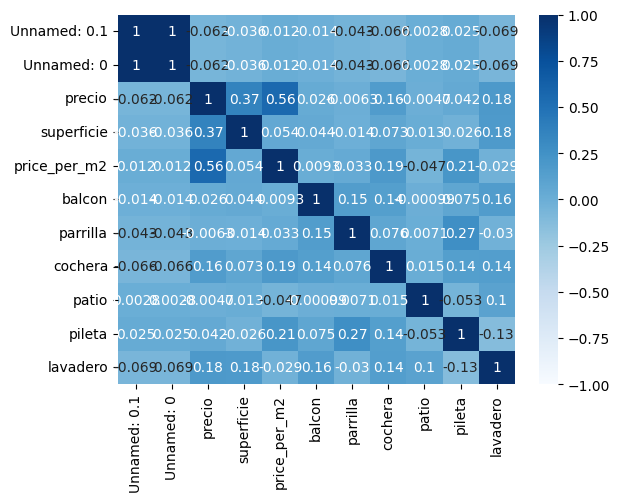

In [ ]:
sns.heatmap(data.corr(), annot=True, vmin=-1, cmap='Blues');

In [ ]:
try:
  data.drop(index=[43567,29617, 29618,29615,35810,32926,49647,49639,49456,36844,2223], inplace=True)
  print("droped")
except:
  pass
print(data)

droped
       Unnamed: 0.1  Unnamed: 0 property_type    precio  superficie  \
8                13          13  Departamento  111700.0        30.0   
9                14          14  Departamento  147900.0        31.0   
14               19          19  Departamento  350000.0        96.0   
15               21          21  Departamento  270500.0        73.0   
30               38          38  Departamento  480000.0       130.0   
...             ...         ...           ...       ...         ...   
77149        121120      121120  Departamento  160000.0        40.0   
77155        121135      121135  Departamento   95000.0        19.0   
77156        121136      121136  Departamento  102000.0        33.0   
77157        121137      121137  Departamento  115000.0        33.0   
77163        121146      121146  Departamento  350000.0        87.0   

       price_per_m2  balcon  parrilla  cochera  patio  pileta  lavadero  
8       3723.333333    True     False    False  False    True     

In [ ]:
data.sort_values(by="superficie").tail(10)

,Unnamed: 0.1,Unnamed: 0,property_type,precio,superficie,price_per_m2,balcon,parrilla,cochera,patio,pileta,lavadero
25171,38261,38261,Departamento,1100000.0,400.0,2750.000000,False,False,True,True,False,True
1989,5497,5497,Departamento,1600000.0,400.0,4000.000000,True,False,False,False,True,True
25224,38346,38346,Departamento,3000000.0,400.0,7500.000000,False,False,False,False,False,False
29611,44675,44675,Departamento,1850000.0,400.0,4625.000000,True,False,False,False,False,True
55221,81885,81885,Departamento,3000000.0,404.0,7425.742574,False,False,False,False,True,False
7758,14064,14064,Departamento,2900000.0,405.0,7160.493827,False,False,True,False,False,False
32071,48182,48182,Departamento,2300000.0,410.0,5609.756098,False,False,True,False,False,False
42677,62888,62888,Departamento,2200000.0,416.0,5288.461538,False,False,False,False,False,True
854,1276,1276,Departamento,2850000.0,431.0,6612.529002,True,False,False,True,False,True
7526,13729,13729,Departamento,3600000.0,470.0,7659.574468,False,False,True,False,True,True


Previo a plantear los modelos preparamos las variables, en este caso, con las categóricas formamos dummies y con las numérica hacemos una normalización de los datos

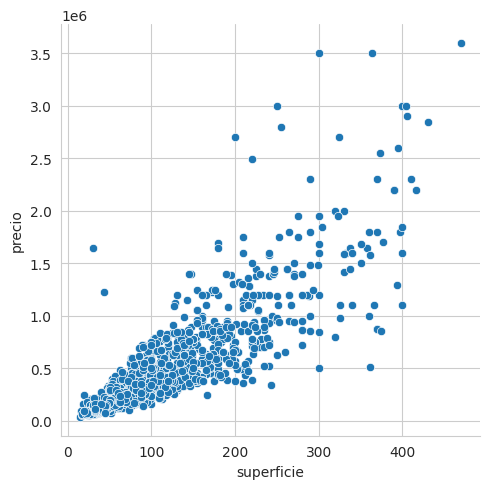

In [ ]:
sns.set_style('whitegrid')
yticks=[0,10000,40000,100000]
sns.relplot(data=data, x='superficie',y='precio');


In [ ]:
# crear variables dummies

balcon_dummies = pd.get_dummies(data.balcon, prefix='balcon')
balcon_dummies.drop(balcon_dummies.columns[0], axis=1, inplace=True)

parrilla_dummies = pd.get_dummies(data.parrilla, prefix='parrilla')
parrilla_dummies.drop(parrilla_dummies.columns[0], axis=1, inplace=True)

cochera_dummies = pd.get_dummies(data.cochera, prefix='cochera')
cochera_dummies.drop(cochera_dummies.columns[0], axis=1, inplace=True)

pileta_dummies = pd.get_dummies(data.pileta, prefix='pileta')
pileta_dummies.drop(pileta_dummies.columns[0], axis=1, inplace=True)

lavadero_dummies = pd.get_dummies(data.lavadero, prefix='lavadero')
lavadero_dummies.drop(lavadero_dummies.columns[0], axis=1, inplace=True)

In [ ]:
numericas = ['precio','superficie']

X = data[numericas]
print(X.shape)
scaler = MinMaxScaler()
scaler.fit(X)

std_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(std_numerical_data)
std_df.columns = [i for i in numericas]
std_df

(3070, 2)


,precio,superficie
0,0.021515,0.032967
1,0.031669,0.035165
2,0.088359,0.178022
3,0.066059,0.127473
4,0.124825,0.252747
...,...,...
3065,0.035063,0.054945
3066,0.016830,0.008791
3067,0.018794,0.039560
3068,0.022440,0.039560


In [ ]:
desnormalized = scaler.inverse_transform(std_numerical_data)
dst_df = pd.DataFrame(desnormalized)
dst_df.columns = [i for i in numericas]
dst_df

,precio,superficie
0,111700.0,30.0
1,147900.0,31.0
2,350000.0,96.0
3,270500.0,73.0
4,480000.0,130.0
...,...,...
3065,160000.0,40.0
3066,95000.0,19.0
3067,102000.0,33.0
3068,115000.0,33.0


Concatenamos las variables

In [ ]:
balcon_dummies.reset_index(drop=True, inplace=True)
parrilla_dummies.reset_index(drop=True, inplace=True)
cochera_dummies.reset_index(drop=True, inplace=True)
pileta_dummies.reset_index(drop=True, inplace=True)
lavadero_dummies.reset_index(drop=True, inplace=True)

data=pd.concat([balcon_dummies, parrilla_dummies, cochera_dummies, pileta_dummies, lavadero_dummies, std_df], axis = 1)
data

,balcon_True,parrilla_True,cochera_True,pileta_True,lavadero_True,precio,superficie
0,1,0,0,1,0,0.021515,0.032967
1,0,0,0,1,0,0.031669,0.035165
2,1,0,0,0,0,0.088359,0.178022
3,0,0,0,0,0,0.066059,0.127473
4,1,1,1,1,0,0.124825,0.252747
...,...,...,...,...,...,...,...
3065,1,1,0,0,0,0.035063,0.054945
3066,1,0,0,0,0,0.016830,0.008791
3067,1,0,0,0,0,0.018794,0.039560
3068,1,0,0,0,0,0.022440,0.039560


Renombramos columnas y volvemos a ver correlaciones entre las variables que nos interesan para el modelo

In [ ]:
data.rename(columns={'balcon_True':'balcon','parrilla_True':'parrilla', 'cochera_True':'cochera', 'pileta_True':'pileta', 'lavadero_True':'lavadero'},inplace=True)

In [ ]:
variable = ['superficie', 'balcon','parrilla', 'cochera', 'pileta','lavadero']

In [ ]:
a=data[variable]
a.corr()

,superficie,balcon,parrilla,cochera,pileta,lavadero
superficie,1.000000,0.081267,-0.007940,0.193716,-0.044509,0.338408
balcon,0.081267,1.000000,0.150372,0.135383,0.075230,0.157168
parrilla,-0.007940,0.150372,1.000000,0.076604,0.274569,-0.029320
cochera,0.193716,0.135383,0.076604,1.000000,0.135811,0.143504
pileta,-0.044509,0.075230,0.274569,0.135811,1.000000,-0.126925
lavadero,0.338408,0.157168,-0.029320,0.143504,-0.126925,1.000000


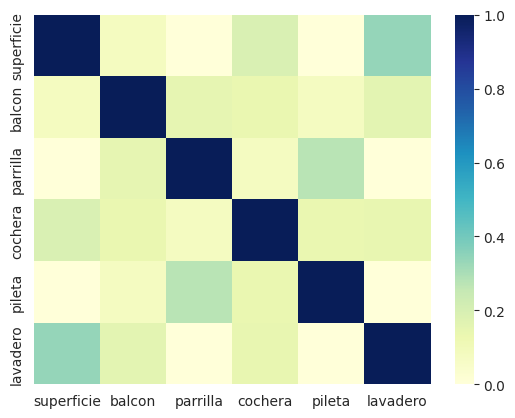

In [ ]:
sns.heatmap(data[variable].corr(), vmin=0, vmax=1, cmap="YlGnBu");

Planteamos un primer modelo de regresión múltiple

In [ ]:
import numpy.random
def train_test_rmse(variable):
    seed=numpy.random.seed(4)
    X = data[variable]
    y = data.precio
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True,random_state=seed)
    linreg = LinearRegression()

    linreg.fit(Xtrain, ytrain)

    ypred_train = linreg.predict(Xtrain)
    ypred_test = linreg.predict(Xtest)
    print (variable)
    print('\n')
    MAE_train = metrics.mean_absolute_error(ytrain, ypred_train)
    MAE_test = metrics.mean_absolute_error(ytest, ypred_test)
    print ('MAE train:', MAE_train)
    print ('MAE test:', MAE_test)
    print(f"Diferencia: {round((MAE_train/MAE_test)*100, 3)} %")
    print('\n')
    MSE_train = metrics.mean_squared_error(ytrain, ypred_train)
    MSE_test = metrics.mean_squared_error(ytest, ypred_test)
    print ('MSE train:', MSE_train)
    print ('MSE test:', MSE_test)
    print(f"Diferencia: {round((MSE_train/MSE_test)*100, 3)} %")
    print('\n')
    RMSE_train = np.sqrt(metrics.mean_squared_error(ytrain, ypred_train))
    RMSE_test = np.sqrt(metrics.mean_squared_error(ytest, ypred_test))
    print ('RMSE train:', RMSE_train )
    print ('RMSE test:', RMSE_test)
    print(f"Diferencia: {round((RMSE_train/RMSE_test)*100, 3)} %")
    print('\n')
    R2_train = metrics.r2_score(ytrain, ypred_train)
    R2_test = metrics.r2_score(ytest, ypred_test)
    print ('R2 train:', R2_train)
    print ('R2 test:', R2_test)
    print(f"Diferencia: {round((R2_train/R2_test)*100,3)} %")

    return Xtrain, Xtest, ytrain, ytest, MAE_test, MSE_test, RMSE_test, R2_test

In [ ]:
Xtrain, Xtest, ytrain, ytest, MAE_test, MSE_test, RMSE_test, R2_test = train_test_rmse(['superficie', 'parrilla', 'cochera', 'pileta', 'lavadero', 'balcon'])
#Xtrain, Xtest, ytrain, ytest= train_test_rmse(['superficie'])

['superficie', 'parrilla', 'cochera', 'pileta', 'lavadero', 'balcon']


MAE train: 0.024494308691275803
MAE test: 0.024957353735357967
Diferencia: 98.145 %


MSE train: 0.0020784539797113685
MSE test: 0.0025443745120805198
Diferencia: 81.688 %


RMSE train: 0.04559006448461516
RMSE test: 0.05044179330753933
Diferencia: 90.382 %


R2 train: 0.7808752017745854
R2 test: 0.7421386536239744
Diferencia: 105.22 %


In [ ]:
variable = ['superficie', 'parrilla', 'cochera', 'pileta', 'lavadero', 'balcon']
X = data[variable]
y = data.precio

In [ ]:
modelo1 = LinearRegression(fit_intercept=True)
modelo1.fit(X, y)

coef_scaled = modelo1.coef_
intercept_scaled = modelo1.intercept_

list(zip(variable, modelo1.coef_))

[('superficie', 0.6311879665194216),
 ('parrilla', -0.004034955429158061),
 ('cochera', 0.005259900398403552),
 ('pileta', 0.019040471264134343),
 ('lavadero', -0.01488115985385166),
 ('balcon', -0.004275961750205726)]

In [ ]:
modelo1.intercept_

-0.009947361881608649

Hacemos el mismo modelo pero usando la librería Statsmodels

In [ ]:
X = data[['superficie', 'parrilla', 'cochera', 'pileta', 'lavadero','balcon']]
#X = data[['superficie', 'cochera', 'pileta', 'lavadero','balcon']]
#X = data[['superficie']]
y = data[["precio"]]
X = sm.add_constant(X)
modelo2 = sm.OLS(y, X).fit()
prediccion = modelo2.predict(X)
print ("EMC:", mean_squared_error(y, prediccion))

modelo2.summary()

EMC: 0.0021915048302308788


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1721.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:56:22   Log-Likelihood:                 5042.9
No. Observations:                3070   AIC:                        -1.007e+04
Df Residuals:                    3063   BIC:                        -1.003e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0099      0.002     -6.029      0.000      -0.013      -0.007
superficie     0.6312      0.007     96.075      0.000       0.618       0.644
parrilla      -0.0040      0.002     -1.850      0.064      -0.008       0.000
cochera        0.0053      0.002      2.669      0.008       0.001       0.009
pileta         0.0190      0.002      9.923      0.000       0.015       0.023
lavadero      -0.0149      0.002     -7.120      0.000      -0.019      -0.011
balcon        -0.0043      0.002     -2.416      0.016      -0.008      -0.001
==============================================================================
Omnibus:                     2341.849   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           155546.879
Skew:                           3.042   Prob(JB):                         0.00
Kurtosis:                      37.336   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se observa que la variable categórica 'parrilla' es no significativa, por lo que se plantea otro modelo multivarido, sin esa variable

In [ ]:
X = data[['superficie', 'cochera', 'pileta', 'lavadero','balcon']]
y = data[["precio"]]
X = sm.add_constant(X)
modelo3 = sm.OLS(y, X).fit()
prediccion = modelo3.predict(X)
print ("EMC:", mean_squared_error(y, prediccion))

modelo3.summary()

EMC: 0.0021939546687078644


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     2063.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:03:00   Log-Likelihood:                 5041.2
No. Observations:                3070   AIC:                        -1.007e+04
Df Residuals:                    3064   BIC:                        -1.003e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.002     -6.240      0.000      -0.013      -0.007
superficie     0.6313      0.007     96.050      0.000       0.618       0.644
cochera        0.0052      0.002      2.618      0.009       0.001       0.009
pileta         0.0181      0.002      9.771      0.000       0.014       0.022
lavadero      -0.0148      0.002     -7.084      0.000      -0.019      -0.011
balcon        -0.0047      0.002     -2.685      0.007      -0.008      -0.001
==============================================================================
Omnibus:                     2336.500   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           156410.921
Skew:                           3.028   Prob(JB):                         0.00
Kurtosis:                      37.439   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El R2 no se modifica pero queda un modelo con todas variables significativas

In [ ]:
#[ 0.73707727, -0.00268944,  0.00973212,  0.01518257, -0.01125051,
#       -0.00242103])

In [ ]:
Xtest['superficie'].shape

(768,)

Se grafica la regresión lineal entre precio y superficie

<Axes: xlabel='superficie', ylabel='precio'>

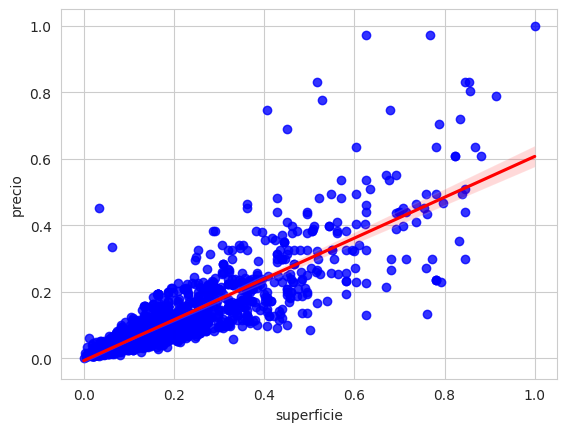

In [ ]:
sns.regplot(x='superficie', y='precio', data=data, ci=95, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

#sns.regplot(x='superficie', y='precio', data=data)

Planteamos regularización y hacemos dos modelos más, uno con Lasso y otro con Ridge

### Lasso

In [ ]:
lassocv = linear_model.LassoCV(alphas=[0.00006,0.00007,0.0001,0.0002, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
#lassocv = linear_model.LassoCV(alphas=[0.00005,0.00004,0.00003], cv=5)
modelo_cv = lassocv.fit(Xtrain, ytrain)
modelo_cv.score(Xtrain, ytrain)


0.7808387488127538

In [ ]:
modelo_cv.coef_

array([ 0.61713235, -0.00352829,  0.004639  ,  0.01672404, -0.01448083,
       -0.00243729])

In [ ]:
modelo_cv.alpha_

6e-05

In [ ]:
modelo_cv.score(Xtrain, ytrain)

0.7808387488127538

In [ ]:
ypred = lassocv.predict(Xtest)

r2 = r2_score(ytest, ypred)
print("R2:", r2)

mse = mean_squared_error(ytest, ypred)
print("MSE:", mse)

mae = mean_absolute_error(ytest, ypred)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(ytest, ypred))
print("RMSE:", rmse)

R2: 0.7414307908049254
MSE: 0.0025513591499106945
MAE: 0.024881316658596275
RMSE: 0.05051098048851056


In [ ]:
print ('MAE MV:', MAE_test)
print("MAE Lasso:", mae)
print(f"Diferencia: {round((MAE_test/mae)*100,3)} %")
print('\n')
print ('MSE MV:', MSE_test)
print("MSE Lasso:", mse)
print(f"Diferencia: {round((MSE_test/mse)*100,3)} %")
print('\n')

print ('RMSE MV:', RMSE_test)
print("RMSE Lasso:", rmse)
print(f"Diferencia: {round((RMSE_test/rmse)*100,3)} %")

print('\n')
print ('R2 MV:', R2_test)
print("R2 Lasso:", r2)
print(f"Diferencia: {round((R2_test/r2)*100,3)} %")

MAE MV: 0.024957353735357967
MAE Lasso: 0.024881316658596275
Diferencia: 100.306 %


MSE MV: 0.0025443745120805198
MSE Lasso: 0.0025513591499106945
Diferencia: 99.726 %


RMSE MV: 0.05044179330753933
RMSE Lasso: 0.05051098048851056
Diferencia: 99.863 %


R2 MV: 0.7421386536239744
R2 Lasso: 0.7414307908049254
Diferencia: 100.095 %


### Ridge

In [ ]:
ridgecv = linear_model.RidgeCV(alphas=[0.00006, 0.00007, 0.0001, 0.0002, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], cv=5)
modelo_cv = ridgecv.fit(Xtrain, ytrain)
print(modelo_cv.coef_)
modelo_cv.score(Xtrain, ytrain)

[ 0.61306999 -0.00396973  0.00518888  0.01699643 -0.01433408 -0.00262206]


0.7807644496702156

In [ ]:
modelo_cv.alpha_

0.5

In [ ]:
ypred = ridgecv.predict(Xtest)

r2 = r2_score(ytest, ypred)
print("R2:", r2)

mse = mean_squared_error(ytest, ypred)
print("MSE:", mse)

mae = mean_absolute_error(ytest, ypred)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(ytest, ypred))
print("RMSE:", rmse)

R2: 0.7409606329084002
MSE: 0.0025559983010878056
MAE: 0.0248549322147384
RMSE: 0.050556881837073436


In [ ]:
print ('MAE MV:', MAE_test)
print("MAE Ridge:", mae)
print(f"Diferencia: {round((MAE_test/mae)*100,3)} %")
print('\n')
print ('MSE MV:', MSE_test)
print("MSE Ridge:", mse)
print(f"Diferencia: {round((MSE_test/mse)*100,3)} %")
print('\n')

print ('RMSE MV:', RMSE_test)
print("RMSE Ridge:", rmse)
print(f"Diferencia: {round((RMSE_test/rmse)*100,3)} %")

print('\n')
print ('R2 MV:', R2_test)
print("R2 Ridge:", r2)
print(f"Diferencia: {round((R2_test/r2)*100,3)} %")

MAE MV: 0.024957353735357967
MAE Ridge: 0.0248549322147384
Diferencia: 100.412 %


MSE MV: 0.0025443745120805198
MSE Ridge: 0.0025559983010878056
Diferencia: 99.545 %


RMSE MV: 0.05044179330753933
RMSE Ridge: 0.050556881837073436
Diferencia: 99.772 %


R2 MV: 0.7421386536239744
R2 Ridge: 0.7409606329084002
Diferencia: 100.159 %


En los dos modelos se obtienen alfas muy bajos